# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/'
import sys
sys.path.append(dataPath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
dataPath = 'data/'

In [2]:
import pickle
import pandas as pd

with open(dataPath + 'recipes_valid.pkl', 'rb') as f:
    pklData = pd.DataFrame(pickle.load(f))

print(pklData.keys())

Index(['title', 'ingredients', 'instructions'], dtype='object')


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [3]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor('data/vocab.bin')

pklData = pklData.iloc[:1000]

out = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [4]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder, RmeParameters

# Import custom helper functions
from src.networkUtils import DataBuilder, CustomLoss, standardize_data, sparse_batch_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Setup Datasets + Hyperparameters

In [5]:
# One hot encoding without embedding and using sparse frame
train_data, test_data, scaler =  standardize_data(out)
batch_size = 1024
# Train/Testdataset split is defined in the DataBuilder
traindata_set=DataBuilder(train_data, standardizer=scaler)
testdata_set=DataBuilder(test_data, standardizer=scaler)
# Definition of batches
trainloader=DataLoader(dataset=traindata_set,batch_size=batch_size)
testloader=DataLoader(dataset=testdata_set,batch_size=batch_size)

In [6]:
params = RmeParameters(testdata_set.x.shape[1])

model = ReciMeEncoder(params).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

### Train Model

In [7]:
epochs = 10
log_interval = 5
val_losses = []
train_losses = []
test_losses = []

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [9]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}'.format(
                epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [10]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

====> Epoch: 5 Average training loss: 54176.1486
====> Epoch: 5 Average test loss: 54022.6067
====> Epoch: 10 Average training loss: 54034.6971
====> Epoch: 10 Average test loss: 53931.3533


2
2


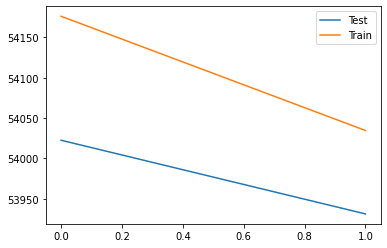

In [11]:
import matplotlib.pyplot as plt
print(len(test_losses))
print(len(train_losses))
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [12]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        break

In [13]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [14]:
scaler = trainloader.dataset.standardizer

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

fake_data = scaler.inverse_transform(pred)
df_fake = pd.DataFrame(fake_data)
df_fake.head(10)

,0,1,2,3,4,5,6,7,8,9,...,6410,6411,6412,6413,6414,6415,6416,6417,6418,6419
0,4.943071,8.201934,0.091817,0.090567,0.039474,6.660518,0.690382,0.012834,0.042411,0.055269,...,2.222643e-07,0.004560,0.004898,2.215368e-07,0.001867,2.078546e-07,1.735657e-07,1.928778e-07,1.964380e-07,0.006693
1,4.242517,10.695867,0.066397,0.108650,0.039307,3.683542,0.617151,0.023706,0.036644,0.023849,...,1.960297e-07,0.004560,0.004898,1.594713e-07,0.001868,2.828481e-07,1.083047e-07,1.304800e-07,1.927069e-07,0.006693
2,3.874870,10.230253,0.184339,0.139703,0.077563,5.163623,1.737402,0.033495,0.071698,0.072961,...,1.501555e-07,0.004560,0.004898,3.220700e-07,0.001868,3.503673e-07,2.013711e-07,1.983819e-07,1.338787e-07,0.006693
3,13.996569,9.241297,0.351852,0.323330,0.121601,2.738028,1.059837,0.109466,0.206977,0.069115,...,1.053196e-06,0.004558,0.004896,1.976766e-06,0.001867,3.741689e-06,2.031399e-06,2.355211e-06,9.274951e-07,0.006692
4,0.797207,12.655395,0.042092,0.015970,0.012088,0.854457,0.337018,0.006464,0.010219,0.012107,...,4.577253e-08,0.004560,0.004899,2.740288e-08,0.001868,9.417411e-08,4.200269e-08,6.251602e-08,4.960614e-08,0.006693
5,0.991164,6.994678,0.068234,0.021727,0.013865,1.313680,0.181001,0.005108,0.026602,0.018796,...,3.264827e-08,0.004560,0.004899,3.382557e-08,0.001868,9.721511e-08,4.322607e-08,7.927575e-08,5.343771e-08,0.006694
6,10.165834,8.471713,0.166998,0.128705,0.062464,2.548008,1.012560,0.040351,0.161886,0.076789,...,5.588428e-07,0.004560,0.004898,5.159982e-07,0.001867,2.159691e-06,7.313870e-07,1.118005e-06,4.581921e-07,0.006693
7,0.991687,9.024988,0.078928,0.043580,0.029847,2.317677,0.271894,0.013968,0.030806,0.023847,...,1.202863e-07,0.004560,0.004898,1.367017e-07,0.001868,2.475025e-07,1.539809e-07,1.549736e-07,9.616669e-08,0.006693
8,15.857577,10.701559,0.417480,0.382683,0.158325,5.476230,1.243577,0.085425,0.088953,0.188158,...,1.021229e-06,0.004559,0.004898,1.607746e-06,0.001867,3.222081e-06,2.209801e-06,1.263575e-06,6.503997e-07,0.006692
9,0.928818,12.879430,0.042526,0.033098,0.020685,2.649346,0.494649,0.006952,0.025817,0.028881,...,4.912208e-08,0.004560,0.004899,3.556354e-08,0.001868,5.253568e-08,2.579786e-08,2.631358e-08,2.657504e-08,0.006693


In [15]:
print(fake_data.shape)
print(type(fake_data))

(20, 6420)
<class 'numpy.ndarray'>


In [16]:
def inverseOneHotEncoding(encoded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in encoded:
        rowTransformed = np.reshape(row, (-1,20))
        rowString = []
        indexTransformed = np.argmax(rowTransformed, axis=1)
        for index in indexTransformed:
            if index:
                rowString.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                rowString.append("")
        output.append(rowString)
    return output

In [17]:
def inverseEmbedding(embedded: np.ndarray, dictionary: dict) -> np.ndarray:
    output = []
    for row in embedded:
        outputRows = []
        for rowTransformed in np.reshape(row, (20,-1)):
            rowTransformed = torch.Tensor(rowTransformed)
            distance = torch.norm(preprocessor.emb.weight.data - rowTransformed, dim=1)
            nearest = torch.argmin(distance)
            index = nearest.item()
            if index:
                outputRows.append(list(dictionary.keys())[list(dictionary.values()).index(index)])
            else:
                outputRows.append("")
        output.append(outputRows)

    return output

In [18]:
def decodeOutput(output: np.ndarray):
    # Split output into amounts, units and ingredients 
    amounts = output[:, :20]
    amountColumns = ['amount_' + str(sub) for sub in list(range(0,20))]
    units = output[:, 20:len(preprocessor.unitDict)*20+20]
    unitColumns = ['unit_' + str(sub) for sub in list(range(0,20))]
    ingredients = output[:, len(preprocessor.unitDict)*20+20:]
    ingredientColumns = ['ingredient_' + str(sub) for sub in list(range(0,20))]
    unitsDecoded = inverseOneHotEncoding(units, preprocessor.unitDict)
    ingredientsDecoded = inverseEmbedding(ingredients, preprocessor.ingredientDict)
    outputFrame = []
    for index in range(len(amounts)):
        array = np.stack((amounts[index], unitsDecoded[index], ingredientsDecoded[index]),axis=1)
        outputFrame.append(pd.DataFrame(array, columns=["amount", "unit", "ingredient"]))
    return outputFrame

df = decodeOutput(fake_data)
df

[           amount              unit ingredient
 0       4.9430714               cup       </s>
 1        8.201934               cup       ways
 2      0.09181671               cup       ways
 3      0.09056705               cup       salt
 4      0.03947389               cup       salt
 5       6.6605177               cup        425
 6       0.6903816               cup    shijimi
 7     0.012833501               cup           
 8      0.04241094               cup           
 9       0.0552693               cup           
 10    0.014862444               cup           
 11      0.0163708                             
 12    0.048994776               cup           
 13       1.203204               cup           
 14    0.013649384                             
 15   0.0071002226               cup           
 16   0.0060476577              inch           
 17   0.0011468575               cup           
 18  0.00070919545               cup           
 19  0.00024821324  cubic centimetre    

In [19]:
data = pklData[:1]['ingredients']

dataEmbedded = np.array(preprocessor.preProcessInput(data))

dataReconverted = decodeOutput(dataEmbedded)
pd.concat([dataReconverted[0], data[0].add_prefix("orig_")], axis=1)

,amount,unit,ingredient,orig_amount,orig_unit,orig_ingredient
0,1.0,,elbow_macaroni,1.0,cup,elbow macaroni
1,1.0,cup,cheese,1,,American cheese
2,0.5,,celery,0.5,cup,celery
3,1.0,cup,green_peppers,1,,green peppers
4,1.0,cup,pimentos,1,,pimentos
5,0.5,,mayonnaise,0.5,cup,mayonnaise
6,1.0,,vinegar,1.0,tablespoon,vinegar
7,0.75,tablespoon,salt,0.75,teaspoon,salt
8,0.5,tablespoon,dill_weed,0.5,teaspoon,dry dill weed
9,0.0,,,NaN,NaN,NaN


In [164]:
string = "dry dill weed"
name_words = string.lower().split(' ')
for i in range(len(name_words)):
    print('_'.join(name_words[i:]))

dry_dill_weed
dill_weed
weed


In [100]:
embeddings = torch.nn.Embedding(1000, 100)
my_sample = torch.randn(1, 100)
distance = torch.norm(embeddings.weight.data - my_sample, dim=1)
nearest = torch.argmin(distance)
print(my_sample.shape)
print(embeddings.weight.data.shape)

torch.Size([1, 100])
torch.Size([1000, 100])


In [ ]:
df_fake_stripped = df_fake.drop(columns=dropColumns)
df_fake_stripped_decoded = pd.DataFrame(data=enc.inverse_transform(df_fake_stripped), columns=frameStripped_cols)
df_fake_decoded = pd.concat([df_fake[dropColumns], df_fake_stripped_decoded], axis=1)
df_fake_decoded

,amount0,amount1,amount2,amount3,amount4,amount5,amount6,amount7,amount8,amount9,...,unit15,ingredient15,unit16,ingredient16,unit17,ingredient17,unit18,ingredient18,unit19,ingredient19
0,64.442848,23.664961,49.338566,-42.998547,-119.452202,-66.648613,-154.251694,-185.356903,-164.724823,-224.806580,...,NaN,NaN,NaN,cilantro,NaN,NaN,pound-mass,NaN,NaN,NaN
1,8.810388,-47.286228,-2.823172,48.635700,-58.550415,-36.557465,-70.178871,-82.703217,-105.573212,-118.754425,...,NaN,parsley,NaN,coriander seeds,NaN,NaN,NaN,cooked rice,NaN,NaN
2,-1.479209,55.904152,50.416714,16.045837,3.950845,-2.350046,-14.598464,30.940853,-32.246025,2.382841,...,NaN,fresh coriander,NaN,NaN,NaN,oranges,NaN,parsnips,NaN,NaN
3,14.182304,2.477328,-3.760162,59.003902,28.163504,-46.981678,-35.794037,11.232952,-42.479977,-37.004219,...,NaN,parsley,NaN,heavy cream,NaN,NaN,NaN,NaN,NaN,NaN
4,-4.144509,0.413773,-8.249460,-11.594110,-7.094406,-10.214097,-33.688137,-15.935955,-122.170860,-67.986969,...,NaN,red wine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,15.411857,-8.295390,-23.451984,29.268505,23.886280,-25.089275,27.983902,-41.818836,-19.926884,-6.036649,...,NaN,red snapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,24.510502,24.927975,-24.636230,4.046587,-88.699768,-59.342678,-70.648712,-126.234207,-101.880051,-116.562057,...,NaN,honey,NaN,NaN,NaN,kashmiri chili powder,pound-mass,NaN,NaN,NaN
7,42.387592,-37.253128,6.229177,-42.571140,-3.960990,-30.770060,-16.483934,-75.723740,-73.279839,-75.188171,...,NaN,fresh parsley,NaN,coriander seeds,NaN,NaN,NaN,NaN,NaN,NaN
8,-17.964615,22.236544,-20.761372,-12.459864,14.089928,-94.008537,14.994526,-2.091276,4.619711,-16.819242,...,NaN,red bell pepper,NaN,NaN,NaN,lemons,NaN,parsnips,NaN,NaN
9,-68.803978,-6.645006,-95.787483,76.462791,27.749420,46.117683,35.983135,82.630394,-34.864960,-64.939857,...,NaN,parmesan cheese,NaN,NaN,NaN,kashmiri chili powder,pound-mass,NaN,NaN,NaN


In [ ]:
class Ingredient:
    def __init__(self, amount, unit, ingredient) -> None:
        self.amount = amount
        self.unit = unit
        self.ingredient = ingredient

    def __repr__(self) -> str:
        return "\nAmount: " + str(self.amount) + "\n Unit: " + str(self.unit) + "\n Ingredient: " + str(self.ingredient)

recipes = []
lenIngredients = int(len(df_fake_decoded.columns)/3)
for value in df_fake_decoded.values:
    ingredients = []
    for index in range(0,lenIngredients):
        frame = []
        frame.append(value[index])
        frame.append(value[(2*index)+lenIngredients])
        frame.append(value[(2*index+1)+lenIngredients])
        ingredients.append(frame)
    recipes.append(ingredients)

pd.DataFrame(recipes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,"[64.4428482055664, cubic centimetre, chocolate...","[23.664960861206055, , lavender]","[49.338565826416016, centimetre, fresh mushrooms]","[-42.9985466003418, teaspoon, potatoes]","[-119.45220184326172, nan, Coleslaw]","[-66.64861297607422, nan, grapefruit juice]","[-154.25169372558594, nan, evaporated milk]","[-185.35690307617188, quart, creole mustard]","[-164.72482299804688, nan, mustard powder]","[-224.80657958984375, nan, low - fat chunky pa...","[-191.13412475585938, nan, nan]","[-198.8765869140625, nan, gravy]","[-167.53050231933594, nan, white pepper]","[-147.92593383789062, nan, baking potatoes]","[-160.70291137695312, nan, nan]","[-145.7584991455078, nan, nan]","[-149.96124267578125, nan, cilantro]","[-128.2501220703125, nan, nan]","[-121.9117660522461, pound-mass, nan]","[-117.51127624511719, nan, nan]"
1,"[8.81038761138916, cubic centimetre, boneless ...","[-47.28622817993164, pint, chicken tenderloins]","[-2.823172092437744, pint, cinnamon schnapps]","[48.63570022583008, , tahini]","[-58.5504150390625, tonne, liquid smoke]","[-36.557464599609375, quart, bean sprouts]","[-70.17887115478516, nan, kidney beans]","[-82.70321655273438, nan, ground cumin]","[-105.57321166992188, nan, flat leaf parsley]","[-118.75442504882812, pint, rosemary sprigs]","[-113.6034927368164, nan, lemon]","[-139.75331115722656, nan, zucchini]","[-130.73011779785156, nan, jalapeno chiles]","[-109.12117767333984, nan, crusty bread]","[-126.45930480957031, nan, nan]","[-122.0693130493164, nan, parsley]","[-107.40736389160156, nan, coriander seeds]","[-106.6261978149414, nan, nan]","[-100.09082794189453, nan, cooked rice]","[-105.52842712402344, nan, nan]"
2,"[-1.4792094230651855, , pitted prunes]","[55.904151916503906, , calvados]","[50.41671371459961, , canola oil]","[16.04583740234375, cup, yellow cling peaches]","[3.9508450031280518, , rye flour]","[-2.350046157836914, tablespoon, ground walnuts]","[-14.598464012145996, tonne, reduced - sodium ...","[30.940853118896484, quart, black licorice]","[-32.24602508544922, tablespoon, prunes]","[2.3828413486480713, , remoulade sauce]","[-15.422608375549316, , dry mustard]","[15.704808235168457, , basil]","[-45.11494827270508, , corn kernels]","[-59.557708740234375, nan, blueberries]","[-61.270484924316406, nan, mozzarella cheese]","[-75.70954132080078, nan, fresh coriander]","[-72.7451171875, nan, nan]","[-78.82942199707031, nan, oranges]","[-80.99940490722656, nan, parsnips]","[-83.17864227294922, nan, nan]"
3,"[14.182304382324219, cubic centimetre, yellow ...","[2.477327823638916, litre, coconut milk]","[-3.760161876678467, tablespoon, yellow onions]","[59.003902435302734, tablespoon, ground fennel]","[28.163503646850586, , paprika]","[-46.9816780090332, tonne, celery seeds]","[-35.794036865234375, litre, lowfat mozzarella...","[11.232952117919922, , pumpernickel bread]","[-42.479976654052734, , boneless skinless salm...","[-37.00421905517578, , creme fraiche]","[-30.61975860595703, , corn]","[-90.59840393066406, pint, chicken stock]","[-84.19925689697266, nan, confectioners' sugar]","[-66.14666748046875, nan, red wine vinegar]","[-57.37556838989258, nan, hot dogs]","[-95.26604461669922, nan, parsley]","[-113.85942077636719, nan, heavy cream]","[-91.63735961914062, nan, nan]","[-99.84430694580078, nan, nan]","[-90.85391998291016, nan, nan]"
4,"[-4.1445088386535645, ounce, French haricots v...","[0.4137726426124573, , white tequila]","[-8.249460220336914, centimetre, pebbles]","[-11.594110488891602, cup, red grapefruit]","[-7.0944061279296875, tablespoon, minced ginger]","[-10.214097023010254, kilogram, barbecue sauce]","[-33.68813705444336, tonne, white vinegar]","[-15.935955047607422, tonne, heavy cream]","[-122.17086029052734, nan, assorted fresh vege...","[-67.98696899414062, pint, fresh gingerroot]","[-103.6115951538086, nan, canned black beans]","[-96.7330093383789, nan, black pepper]","[-89.1006088256836, nan, confectioners' sugar]","[-12